# Credit Card Fraud Risk
Reinesse Wong, Melanie Wang, Scarlett Francini, Avalon Bennett

This project aims to utilize autoencoders to build a model that can detect credit card fraud. For our project we will use kaggle dataset "Credit Card Fraud Detection" and "cred Card Fraud" which are linked below.

### Dataset 1:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud - This dataset has already been preprocessed with PCA for anonymity

### Dataset 2:
https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud - This is synthetic credit card data that has not been preprocessed and contains original column data. We will use this dataset if we run into any issues with the data that has already been transformed with PCA


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses, Input, ops
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score , average_precision_score
from sklearn.linear_model import LogisticRegression

# Exploratory Data Analysis

In [ ]:
original_df = pd.read_csv('creditcard.csv')

## After importing data, we first take a look at the overall dataset to see it's attributes
original_df.head()
original_df.info() # Here, we can see the number of transaction is 284,807
# Next, we can see some of statistical descriptions about the overall dataset. This is hard to interpret since the data has already been processed for PCA
original_df.describe()

'''Although there seem to be none, we try to drop any null values if there are any'''
original_df = original_df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

'There are 492 fraduent transactions. This demonstrates that our dataset has a significant class imbalance, with only 0.172% of transactions being fraudulent.'

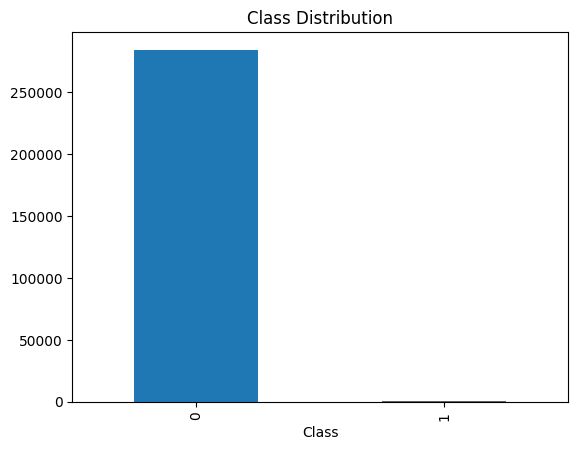

In [ ]:
## Next, we can check visualization of Fraud vs. Non-Fraud Class Balance
original_df['Class'].value_counts(normalize = True)
original_df['Class'].value_counts().plot(kind='bar', title='Class Distribution')

'''There are 492 fraduent transactions. This demonstrates that our dataset has a significant class imbalance, with only 0.172% of transactions being fraudulent.'''

## We can also visualize the distribution of data for transaction amounts

# Preprocess Data
We took the following steps to preprocess the data to prepare it for the autoencoder:
1. Shuffle dataset since it is ordered by date time
2. Scale the columns that are not already normalized from PCA (time and class)
3. Split the dataset to only contain class = 0 to train on non-fraud data
4. Train/Test Split

In [ ]:
original_df = pd.read_csv('creditcard.csv')
original_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
from sklearn.utils import shuffle
df = original_df.copy()
df = shuffle(df, random_state=42)

In [ ]:
X = df.drop(columns=['Class'])
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, stratify=y,shuffle=True, random_state=42)

In [ ]:
scaler_time = StandardScaler()
scaler_amount = StandardScaler()

#scaler on trainng data
X_train['Time'] = scaler_time.fit_transform(X_train[['Time']])
X_train['Amount'] = scaler_amount.fit_transform(X_train[['Amount']])

# scaler on test data
X_test['Time'] = scaler_time.transform(X_test[['Time']])
X_test['Amount'] = scaler_amount.transform(X_test[['Amount']])

X_train_normal = X_train[y_train == 0] #only for normal data

In [ ]:
normal = df[df['Class'] == 0]
normal = normal.drop(columns=['Class'])
fraud = df[df['Class'] == 1]
normal.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89
101565,67878.0,-0.641330,-0.057304,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,...,0.618411,-1.231634,0.257164,-0.371953,-0.038566,1.397514,-0.665947,0.031003,0.180357,100.00


# Autoencoder Setup
Setup the encoder and decoder. The following code was adapted from ps7 and edited to acccount for the input dimension and dfferent layers. We do not need a Flatten() or any reshaping because our input is not an image and our data is tabular. We would have 30 features.

In [ ]:

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = X_train.shape[1]
latent_dim = 8

autoencoder = Autoencoder(latent_dim)

autoencoder.build((None, input_dim))
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'autoencoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


713/713 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.1029 - val_loss: 0.9354
Epoch 2/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8931 - val_loss: 0.9087
Epoch 3/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8722 - val_loss: 0.9004
Epoch 4/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8604 - val_loss: 0.8937
Epoch 5/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8543 - val_loss: 0.8882
Epoch 6/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8344 - val_loss: 0.8833
Epoch 7/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8394 - val_loss: 0.8805
Epoch 8/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8381 - val_loss: 0.8789
Epoch 9/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8365 - val_loss: 0.8772
Epoch 10/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8283 - val_loss: 0.8765
Epoch 11/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8291 - val_loss: 0.8754
Epoch 12/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

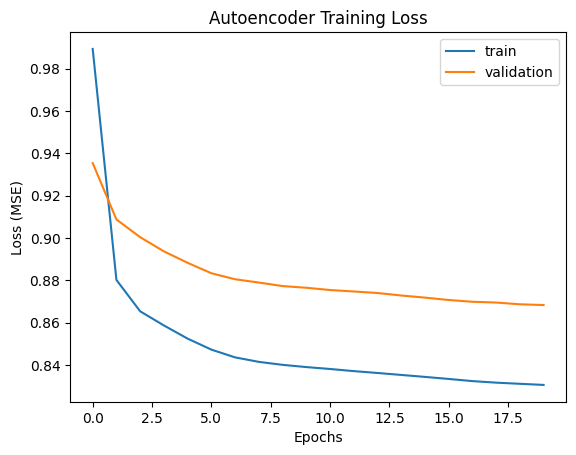

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss (MSE)")  # Y-axis label
plt.show()

## Observations
#### Loss Values are pretty large for the mean squared error
Given that our dataset has already been preprocessed with PCA the loss values being between 0.8 - 1.0 is pretty high menaing that it is off by 0.9 per feature. This means our model is not reconstructing well. We had a few thoughts on this. First, that our dataset was transformed by PCA which is affecting this. Second we are going to edit our model to a gradual compression from 30 - 24 - 16 - 8 instead of 30 - 16 - 8. We also do not want sigmoid as the output because our values aren't between [0,1].

# Editing Our Model

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Dense(30, activation='relu'),
            layers.Dense(24, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(30, activation='relu'),
            layers.Dense(24, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = X_train.shape[1]
latent_dim = 8

autoencoder = Autoencoder(latent_dim)

autoencoder.build((None, input_dim))
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'autoencoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


713/713 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8450 - val_loss: 0.5120
Epoch 2/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4560 - val_loss: 0.4046
Epoch 3/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3865 - val_loss: 0.3687
Epoch 4/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3497 - val_loss: 0.3340
Epoch 5/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3192 - val_loss: 0.3172
Epoch 6/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3111 - val_loss: 0.3125
Epoch 7/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3041 - val_loss: 0.3235
Epoch 8/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3023 - val_loss: 0.3036
Epoch 9/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2956 - val_loss: 0.3072
Epoch 10/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2963 - val_loss: 0.3045
Epoch 11/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2957 - val_loss: 0.2997
Epoch 12/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.

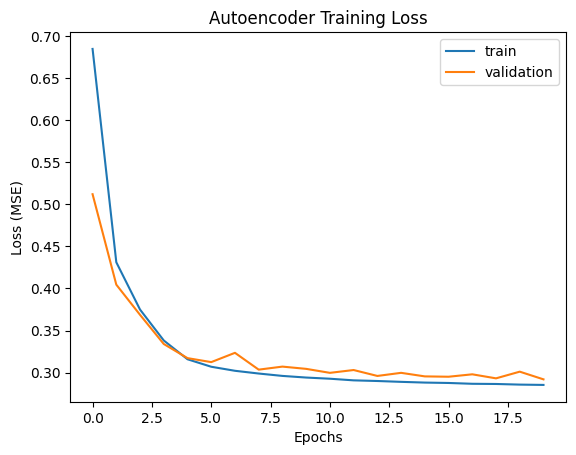

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss (MSE)")  # Y-axis label
plt.show()

This looks much better since there is a curve that shows it decreasing a lot at the beginning and start to flatten around epoch 12-20. the loss and validation loss are almost equivalent which means that our model is generalizing unseen data well. There also isn't overfitting since there isn't a big gap between the loss and validation loss.

# Anomaly Detection
Work on reconstruction error for test samples and deciding threshold boundary. First we need to drop class column from our dataset in order to test the efficacy of our model. We will then split train and test set and create a train set containing only normal data.

In [ ]:
# df.head()
# X = df.drop(columns=['Class'])
# y = df['Class']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# X_train_normal = X_train[y_train == 0] #only for normal data


### Get Reconstruction Error
The reconstruction error

In [ ]:
def reconstruction_errors(model, X):
    recon = model.predict(X, batch_size=256)
    mse = np.mean(np.square(X - recon), axis=1)
    return mse
mse_train_normal = reconstruction_errors(autoencoder, X_train_normal)

mse_test = reconstruction_errors(autoencoder, X_test)

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
print(mse_test)

178217    0.204657
207238    0.480660
162628    0.255473
272256    0.268463
176592    0.186411
            ...   
22057     0.083266
3003      0.101730
202615    0.117511
51052     0.157996
232210    0.282845
Length: 56962, dtype: float64


### Finding Threshold
The quickest way to find the threshold is to pick the 99th percentile of error. This is because if we treat the top most 1% of *normal* transactions as the most unusual, we are assuming that fraudulent transactions would have a higher reconstruction error than a normal one.

In [ ]:
threshold = np.percentile(mse_train_normal, 99)
print("Chosen threshold:", threshold)

y_pred_test = (mse_test > threshold).astype(int) #fraud = 1, nonfraud = 0


Chosen threshold: 1.5123976364402036


In [ ]:
y_pred_test = (mse_test > threshold).astype(int)

### Finetuning Threshold Using Labels
Since we have labels on fraud versus nonfraud, we can choose a threshold that optimizes F1  or recall because of the imbalance in our dataset.

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mse_test)

f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", f1_scores[best_idx])
print("Precision at best F1:", precision[best_idx])
print("Recall at best F1:", recall[best_idx])

y_pred_test = (mse_test > best_threshold).astype(int)

Best threshold: 5.67348691658813
Best F1: 0.4196428522209822
Precision at best F1: 0.373015873015873
Recall at best F1: 0.47959183673469385


## Classification Report on Model Using 99% Percentile Threshold

Looking ar our output we want to particularly focus on recall for fraud (Class = 1) since that counts how many fraud cases we catch and precision for fraud (Class = 1) since that is catching the false positives

#### Results:
Recall = 0.8265
- Model catches about 82.6% of fraud cases

Precision = 0.1254
- Of all the transactions we flagged as fraud, only 12.5% of them were actually fraud
- expected because anomaly detectors prioritize catching rare events and often produce more alerts than actual frauds
- AUC score of 0.948 indicates strong discrimination ability between normal and fraudulent transactions

In [ ]:
threshold = np.percentile(mse_train_normal, 99)
print("Chosen threshold:", threshold)

y_pred_test = (mse_test > threshold).astype(int) #fraud = 1, nonfraud = 0

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred_test, digits=4))

roc_auc = roc_auc_score(y_test, mse_test) #with score
print("ROC AUC (using reconstruction error):", roc_auc)

Chosen threshold: 1.5123976364402036
Confusion matrix:
 [[56299   565]
 [   17    81]]

Classification report:
              precision    recall  f1-score   support

           0     0.9997    0.9901    0.9949     56864
           1     0.1254    0.8265    0.2177        98

    accuracy                         0.9898     56962
   macro avg     0.5625    0.9083    0.6063     56962
weighted avg     0.9982    0.9898    0.9935     56962

ROC AUC (using reconstruction error): 0.9485966516601012


## Classification Report on Model Using "Best" Threshold based on F1

#### Results:
Recall = 0.8878
- Model catches about 88.7% of fraud cases

Precision = 0.0094
- Of all the transactions we flagged as fraud, only 9.4% of them were actually fraud
- expected because anomaly detectors prioritize catching rare events and often produce more alerts than actual frauds
- AUC score of 0.948 indicates strong discrimination ability between normal and fraudulent transactions

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mse_test)

f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", f1_scores[best_idx])
print("Precision at best F1:", precision[best_idx])
print("Recall at best F1:", recall[best_idx])

y_pred_best = (mse_test > precision[best_idx]).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred_best, digits=4))

roc_auc = roc_auc_score(y_test, mse_test)
print("\nROC AUC (using reconstruction error as score):", roc_auc)

Best threshold: 5.67348691658813
Best F1: 0.4196428522209822
Precision at best F1: 0.373015873015873
Recall at best F1: 0.47959183673469385

Confusion matrix:
 [[47652  9212]
 [   11    87]]

Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.8380    0.9118     56864
           1     0.0094    0.8878    0.0185        98

    accuracy                         0.8381     56962
   macro avg     0.5046    0.8629    0.4651     56962
weighted avg     0.9981    0.8381    0.9102     56962


ROC AUC (using reconstruction error as score): 0.9485966516601012


# Baseline Comparison
Use logistic regression as our baseline to view the efficacy of our model we built

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score
import numpy as np
import pandas as pd
#Log
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_score_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

pr_auc_lr = average_precision_score(y_test, y_score_lr)
print(f"Logistic Regression PR AUC: {pr_auc_lr:.4f}")

# Autoencoder
reconstructions = autoencoder.predict(X_test)
mse_test = np.mean((X_test - reconstructions)**2, axis=1)

# mse_test is an anomaly score (higher = more likely fraud)
pr_auc_ae = average_precision_score(y_test, mse_test)
print(f"Autoencoder PR AUC: {pr_auc_ae:.4f}")


results = pd.DataFrame({
    "Model": ["Logistic Regression", "Autoencoder"],
    "PR AUC": [pr_auc_lr, pr_auc_ae]
})

results


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Logistic Regression PR AUC: 0.7071
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Autoencoder PR AUC: 0.2622


,Model,PR AUC
0,Logistic Regression,0.707089
1,Autoencoder,0.262238


# Visuals
Might not end up including because not too informative. Maybe we can do a demo?
overlap of orange bceause model fails to catch them or their reconstruction error is too high

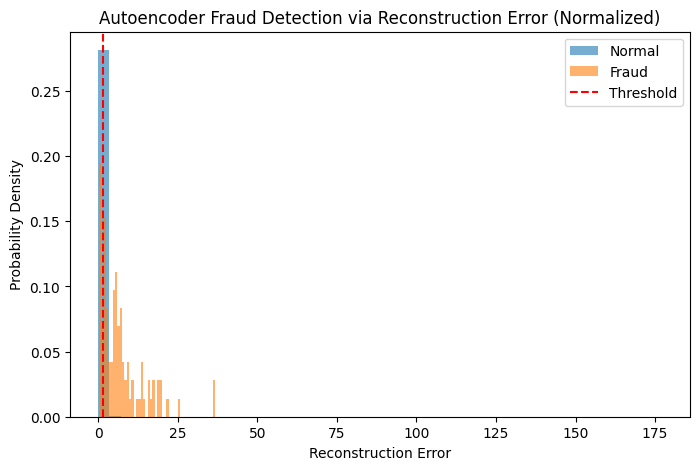

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(
    mse_test[y_test == 0],
    bins=50,
    alpha=0.6,
    label='Normal',
    density=True
)

plt.hist(
    mse_test[y_test == 1],
    bins=50,
    alpha=0.6,
    label='Fraud',
    density=True
)

plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Probability Density")
plt.title("Autoencoder Fraud Detection via Reconstruction Error (Normalized)")
plt.show()

# Demo

In [ ]:
def predict_and_show(x):
    recon = autoencoder.predict(x.reshape(1, -1))[0]
    mse = np.mean((x - recon)**2)
    is_fraud = mse > threshold
    print("Reconstruction Error:", round(mse,4))
    print("Threshold:", round(threshold,4))
    if is_fraud:
      return f"This transaction was flagged as potentially fraudulent since {round(mse,4)} > {round(threshold,4)}"
    else:
      return f"This transaction is not marked as fraud since our mse {round(mse,4)} is less than our threshold"
    return is_fraud


In [ ]:
X_test.shape
randint = np.random.randint(0, X_test.shape[0])
print(f"Testing transaction number {randint}")
predict_and_show(X_test.iloc[randint].values)

Testing transaction number 40099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Reconstruction Error: 0.2732
Threshold: 1.5124


'This transaction is not marked as fraud since our mse 0.2732 is less than our threshold'